In [2]:
!pip install pygam
!pip install statsmodels==0.13.5
!pip install --force-reinstall numpy==1.26.0 pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.4
    Uninstalling statsmodels-0.14.4:
      Successfully uninstalled statsmodels-0.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.5 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 28.0 MB/s eta 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # charts plotting
import plotly.graph_objects as go # more customized plotting
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
pd.set_option("display.max_columns", None)


# Data Visualization
from plotnine import *

# Modeling
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, ExpectileGAM, s, l, f
import statsmodels.api as sm

In [11]:
df_train = pd.read_csv('/content/drive/MyDrive/Spinmaster/train_data.csv')
df_train1 = df_train[~df_train['InvoiceNo'].str.contains('C', na=False)]

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

df_train1 = remove_outliers_iqr(df_train1, 'UnitPrice')
df_train1['InvoiceDate'] = pd.to_datetime(df_train1['InvoiceDate'])
df_train1 = df_train1.sort_values(by='InvoiceDate', ascending=True)
df_train1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08
2,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748,United Kingdom,204.00
3,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,15.30
4,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,15.30


In [24]:
# Time based features
df_train2 = df_train1.copy()
df_train2['InvoiceDayOfWeek'] = df_train2['InvoiceDate'].dt.dayofweek
# Monday=0, Sunday=6
df_train2['IsWeekend'] = df_train2['InvoiceDayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Month
df_train2['Month'] = df_train2['InvoiceDate'].dt.month
df_train2.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceDayOfWeek,IsWeekend,Month
7463,552949,82484,WOOD BLACK BOARD ANT WHITE FINISH,6,2011-05-12 12:01:00,7.95,16033,United Kingdom,47.70,3,0,5
9604,556808,47566,PARTY BUNTING,16,2011-06-14 15:45:00,4.95,17749,United Kingdom,79.20,1,0,6
2556,541875,85099B,JUMBO BAG RED RETROSPOT,10,2011-01-24 10:01:00,1.95,16558,United Kingdom,19.50,0,0,1
11430,560504,22423,REGENCY CAKESTAND 3 TIER,16,2011-07-19 11:47:00,10.95,13081,United Kingdom,175.20,1,0,7
14768,567668,22197,POPCORN HOLDER,2,2011-09-21 15:29:00,1.63,99999,United Kingdom,3.26,2,0,9


In [49]:
# Product Purchase Frequency - Cumulative sum of Purchase frequency of a product upto that Invoice date
df_train3 = df_train2.copy()
df_train3['InvoiceDate_str'] = df_train3['InvoiceDate'].astype(str)
invoice_counts = df_train3.groupby(['StockCode', 'InvoiceDate_str'])['InvoiceNo'].count().reset_index()
invoice_counts = invoice_counts.rename(columns={'InvoiceNo': 'InvoiceCount'})
invoice_counts = invoice_counts.sort_values(['StockCode', 'InvoiceDate_str'])
invoice_counts['CumulativeInvoiceCount'] = invoice_counts.groupby('StockCode')['InvoiceCount'].cumsum()
df_train3 = pd.merge(df_train3, invoice_counts[['StockCode', 'InvoiceDate_str', 'CumulativeInvoiceCount']], on=['StockCode', 'InvoiceDate_str'], how='left')
df_train3 = df_train3.drop(columns=['InvoiceDate_str','CumulativeInvoiceCount_y']).rename(columns={'CumulativeInvoiceCount_x': 'Product_Purchase_Freq'})
df_train3.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceDayOfWeek,IsWeekend,Month,Product_Purchase_Freq
4581,548708,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3,2011-04-03 12:41:00,2.95,13269,United Kingdom,8.85,6,1,4,733
2996,544206,22502,PICNIC BASKET WICKER SMALL,1,2011-02-17 10:33:00,8.29,99999,United Kingdom,8.29,3,0,2,132
12904,568193,85099B,JUMBO BAG RED RETROSPOT,10,2011-09-25 14:37:00,2.08,17107,United Kingdom,20.80,6,1,9,1458
7721,555923,22178,VICTORIAN GLASS HANGING T-LIGHT,6,2011-06-07 17:09:00,2.46,99999,United Kingdom,14.76,1,0,6,534
12342,566952,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-09-15 16:37:00,5.79,99999,United Kingdom,5.79,3,0,9,1633


In [54]:
# Product Purchase Recency -  Calculate time elapsed between last invoice date and current invoice date for each StockCode
df_train4 = df_train3.copy()
df_train4['Product_Purchase_Recency'] = df_train4.groupby('StockCode')['InvoiceDate'].diff().dt.total_seconds()/3600
df_train4.dropna(subset = ["Product_Purchase_Recency"],inplace=True)
df_train4.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceDayOfWeek,IsWeekend,Month,Product_Purchase_Freq,Product_Purchase_Recency
5667,551858,23298,SPOTTY BUNTING,1,2011-05-04 15:33:00,4.95,18041,United Kingdom,4.95,2,0,5,3,0.833333
9605,560291,22386,JUMBO BAG PINK POLKADOT,3,2011-07-18 10:17:00,4.13,99999,United Kingdom,12.39,0,0,7,668,0.000000
5450,551194,22386,JUMBO BAG PINK POLKADOT,1,2011-04-27 11:12:00,2.08,14606,United Kingdom,2.08,2,0,4,367,1.133333
9833,560826,22178,VICTORIAN GLASS HANGING T-LIGHT,96,2011-07-21 11:30:00,1.06,18073,United Kingdom,101.76,3,0,7,632,19.500000
3457,545534,85099B,JUMBO BAG RED RETROSPOT,10,2011-03-03 14:05:00,1.95,17652,United Kingdom,19.50,3,0,3,350,0.333333


In [56]:
# Encoding Categorical - Month and StockCode
df_train5 = df_train4.copy()
df_train5['month_num'] = df_train5['Month'].apply(lambda x: (x - 1) % 12 + 1)

# Apply sine and cosine transformation
df_train5['month_sin'] = np.sin(2 * np.pi * df_train5['month_num'] / 12)
df_train5['month_cos'] = np.cos(2 * np.pi * df_train5['month_num'] / 12)

# Target Encoding for Each Stockcode
# Calculate the mean of 'Quantity' for each 'StockCode'

stockcode_target_encoding = df_train5.groupby('StockCode')['Quantity'].mean()

# # Merge the target encoding back into the main DataFrame
df_train5['StockCode_TargetEncoded'] = df_train5['StockCode'].map(stockcode_target_encoding)

df_train5.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceDayOfWeek,IsWeekend,Month,Product_Purchase_Freq,Product_Purchase_Recency,month_num,month_sin,month_cos,StockCode_TargetEncoded
2000,541422,85099B,JUMBO BAG RED RETROSPOT,5,2011-01-17 17:48:00,4.13,99999,United Kingdom,20.65,0,0,1,168,0.066667,1,5.000000e-01,8.660254e-01,21.737858
8481,557745,23084,RABBIT NIGHT LIGHT,2,2011-06-22 12:16:00,2.08,15750,United Kingdom,4.16,2,0,6,122,1.800000,6,1.224647e-16,-1.000000e+00,8.578544
2574,543040,21137,BLACK RECORD COVER FRAME,2,2011-02-02 17:06:00,3.75,17337,United Kingdom,7.50,2,0,2,41,1.300000,2,8.660254e-01,5.000000e-01,30.355450
12617,567656,22178,VICTORIAN GLASS HANGING T-LIGHT,13,2011-09-21 14:40:00,2.46,14096,United Kingdom,31.98,2,0,9,777,1.650000,9,-1.000000e+00,-1.836970e-16,22.310692
10247,561818,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2,2011-07-29 15:51:00,2.95,16775,United Kingdom,5.90,4,0,7,1401,3.800000,7,-5.000000e-01,-8.660254e-01,19.274738


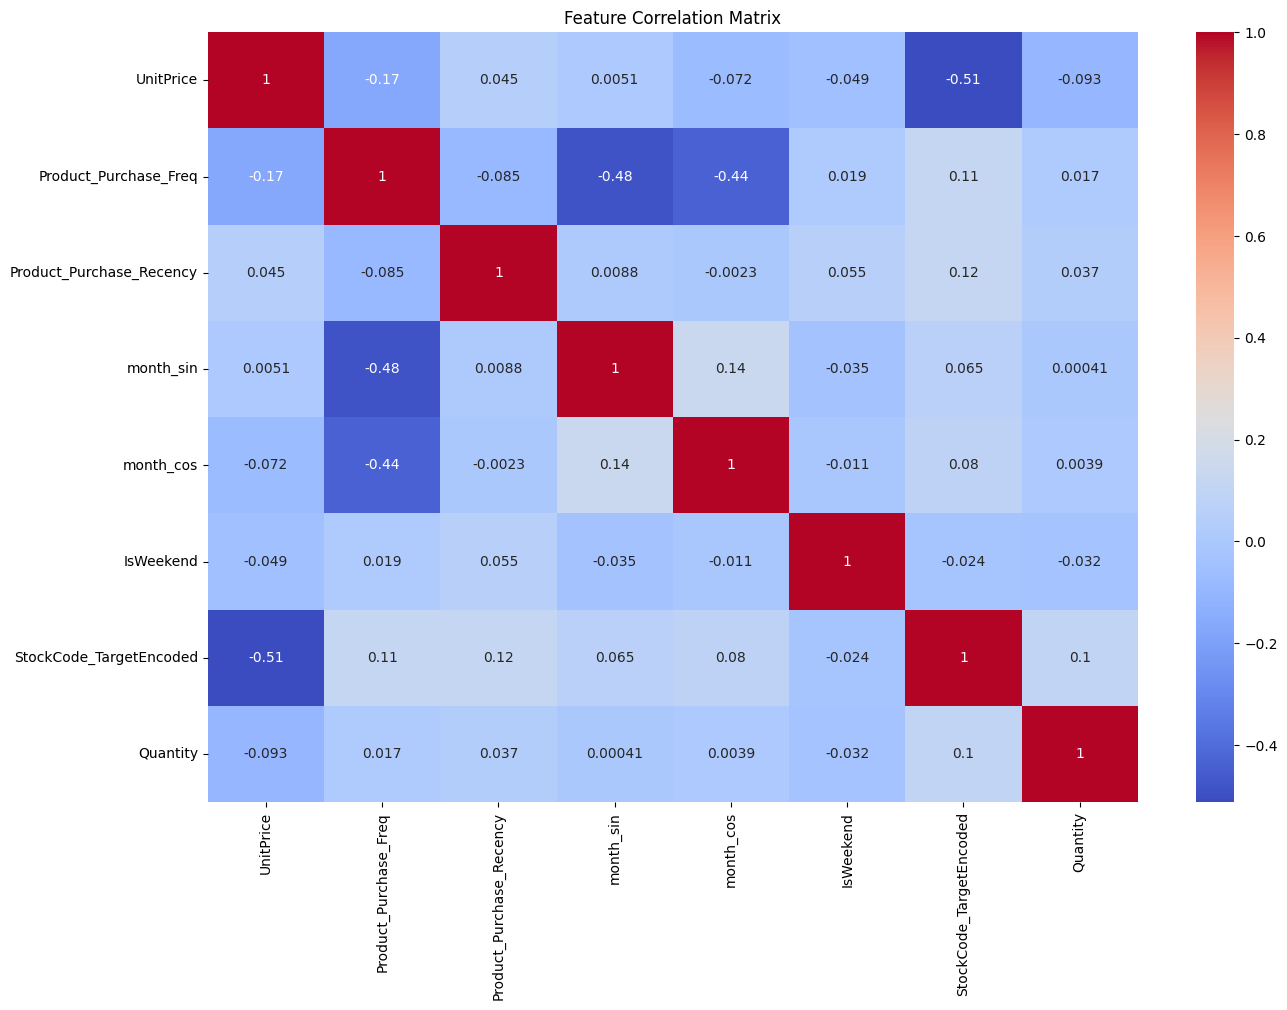

In [59]:
feat_sel = ['UnitPrice', 'Product_Purchase_Freq', 'Product_Purchase_Recency',
            'month_sin', 'month_cos','IsWeekend', 'StockCode_TargetEncoded']
target = 'Quantity'

# Create correlation matrix visualization
plt.figure(figsize=(15, 10))
correlation_matrix = df_train5[feat_sel + ["Quantity"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [60]:
X_train = df_train5[feat_sel]
y_train = df_train5[target]
X = sm.add_constant(X_train) # adding intercept
y = y_train

# Model Fit
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     28.66
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           1.72e-39
Time:                        05:53:49   Log-Likelihood:                -76537.
No. Observations:               13281   AIC:                         1.531e+05
Df Residuals:                   13273   BIC:                         1.532e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

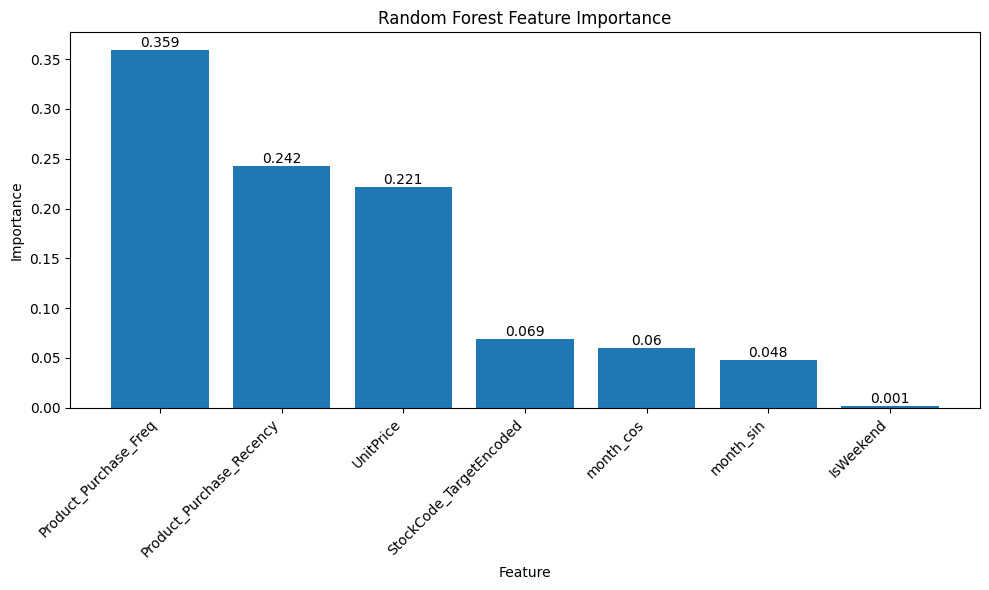

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Assuming X_train and y_train are defined as in your original code
model_rf = RandomForestRegressor(n_estimators=100, random_state=42) # You can adjust hyperparameters
model_rf.fit(X_train, y_train)

# Get feature importances
importances = model_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting feature importances with data labels
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45, ha='right')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center')

plt.tight_layout()
plt.show()


In [62]:
df_train4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceDayOfWeek,IsWeekend,Month,Product_Purchase_Freq,Product_Purchase_Recency
3,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,15.3,2,0,12,2,0.600000
4,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,15.3,2,0,12,3,0.500000
7,536381,22086,PAPER CHAIN KIT 50'S CHRISTMAS,4,2010-12-01 09:41:00,2.95,15311,United Kingdom,11.8,2,0,12,2,0.683333
12,536388,22469,HEART OF WICKER SMALL,12,2010-12-01 09:59:00,1.65,16250,United Kingdom,19.8,2,0,12,2,0.100000
14,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,163.2,2,0,12,4,0.783333


In [70]:
feat_sel = ['UnitPrice', 'Product_Purchase_Freq', 'Product_Purchase_Recency',
            'Month', 'IsWeekend']
target = 'Quantity'

all_gam_results = pd.DataFrame()
unique_prod = df_train4['StockCode'].unique()
for product in unique_prod:
    # Filter for current product
    # Use .loc accessor for indexing and filtering to avoid potential ambiguity
    product_data = df_train4.loc[df_train4['StockCode'] == product]

    # Predictors & target split
    X = product_data[feat_sel]
    y = product_data['Quantity']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0) + l(1) + l(2) + f(3) + f(4), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate results column-wise with the original data
    # Ensure 'price' and 'Product' columns are actually present in your DataFrame
    predictions_gam_df = pd.concat([product_data[['UnitPrice', 'StockCode','Quantity']], predictions_gam], axis=1)

    # Concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)
    all_gam_results

In [71]:
all_gam_results

,UnitPrice,StockCode,Quantity,pred_0.025,pred_0.5,pred_0.975
3,2.55,85123A,6,14.979946,55.435806,349.907998
4,2.55,85123A,6,14.983634,55.440145,349.944605
14,2.55,85123A,64,14.998322,55.448222,349.904513
19,2.55,85123A,32,14.991967,55.449149,350.011150
22,2.55,85123A,6,14.994699,55.453163,350.054427
...,...,...,...,...,...,...
13098,4.13,23084,10,-10.089826,6.167039,16.564023
13104,4.13,23084,7,-9.829824,7.252731,20.270549
13111,4.13,23084,7,-9.813062,7.342809,20.459294
13249,0.00,23084,3,-383.037306,-4.003918,292.444591


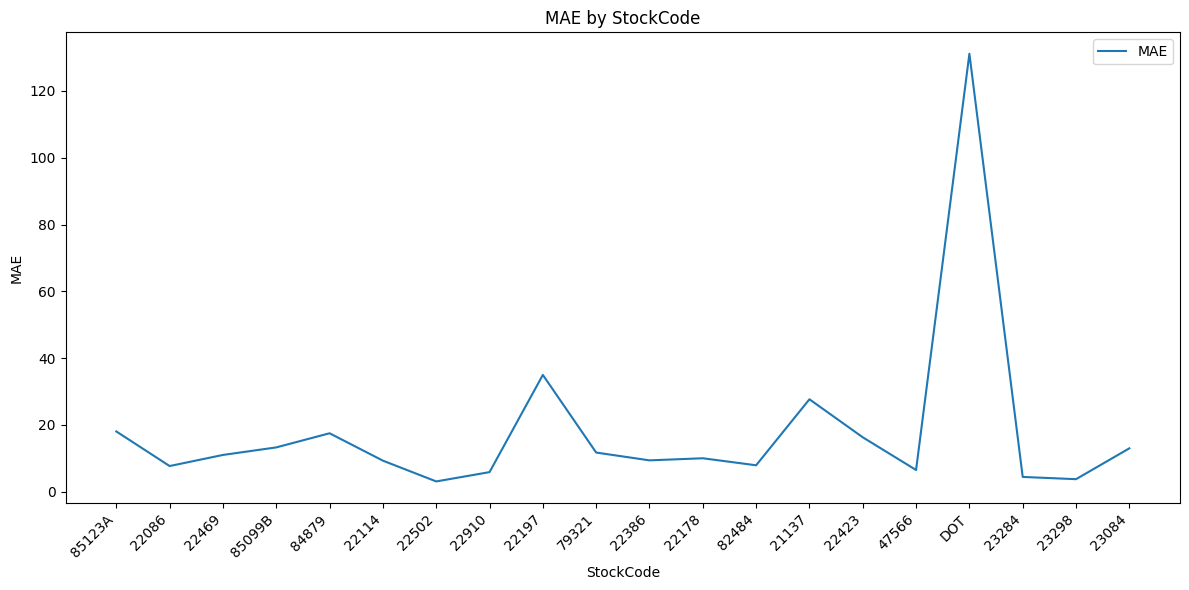

In [79]:
# Metrics - RMSE and MAE
# rmse_df = pd.DataFrame(columns=['StockCode', 'RMSE'])

# for stock_code in all_gam_results['StockCode'].unique():
#     stock_data = all_gam_results[all_gam_results['StockCode'] == stock_code]
#     rmse_values = []
#     for col in ['pred_0.025', 'pred_0.5', 'pred_0.975']:
#         rmse = np.sqrt(mean_squared_error(stock_data['Quantity'], stock_data[col]))
#         rmse_values.append(rmse)
#     avg_rmse = np.mean(rmse_values)
#     rmse_df = pd.concat([rmse_df, pd.DataFrame({'StockCode': [stock_code], 'RMSE': [avg_rmse]})], ignore_index=True)

def calculate_mae(df, quantiles):
  """Calculates the MAE for each quantile and averages over them."""
  mae_values = {}
  for q in quantiles:
    mae = mean_absolute_error(df['Quantity'], df[f'pred_{q}'])
    mae_values[q] = mae
  return mae_values

quantiles = [0.5]
mae_by_stockcode = {}

for stockcode in all_gam_results['StockCode'].unique():
    stock_data = all_gam_results[all_gam_results['StockCode'] == stockcode]
    mae_by_stockcode[stockcode] = calculate_mae(stock_data, quantiles)


# Average MAE across quantiles for each stock code
average_mae = {}
for stockcode, mae_values in mae_by_stockcode.items():
    average_mae[stockcode] = sum(mae_values.values()) / len(mae_values)

# Create a DataFrame from the results
mae_df = pd.DataFrame(list(average_mae.items()), columns=['StockCode', 'Average_MAE'])

# df_metrics1 = pd.merge(rmse_df, mae_df, on='StockCode', how='inner')

plt.figure(figsize=(12, 6))
# plt.plot(df_metrics1['StockCode'], df_metrics1['RMSE'], label='RMSE')
plt.plot(mae_df['StockCode'], mae_df['Average_MAE'], label='MAE')

plt.xlabel('StockCode')
plt.ylabel('MAE')
plt.title('MAE by StockCode')
plt.legend()
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [77]:
all_gam_results_uni = pd.DataFrame()
unique_prod = df_train4['StockCode'].unique()
for product in unique_prod:
    # Filter for current product
    # Use .loc accessor for indexing and filtering to avoid potential ambiguity
    product_data = df_train4.loc[df_train4['StockCode'] == product]

    # Predictors & target split
    X = product_data['UnitPrice']
    y = product_data['Quantity']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate results column-wise with the original data
    # Ensure 'price' and 'Product' columns are actually present in your DataFrame
    predictions_gam_df = pd.concat([product_data[['UnitPrice', 'StockCode','Quantity']], predictions_gam], axis=1)

    # Concatenate results row-wise
    all_gam_results_uni = pd.concat([all_gam_results_uni, predictions_gam_df], axis=0)
    all_gam_results_uni

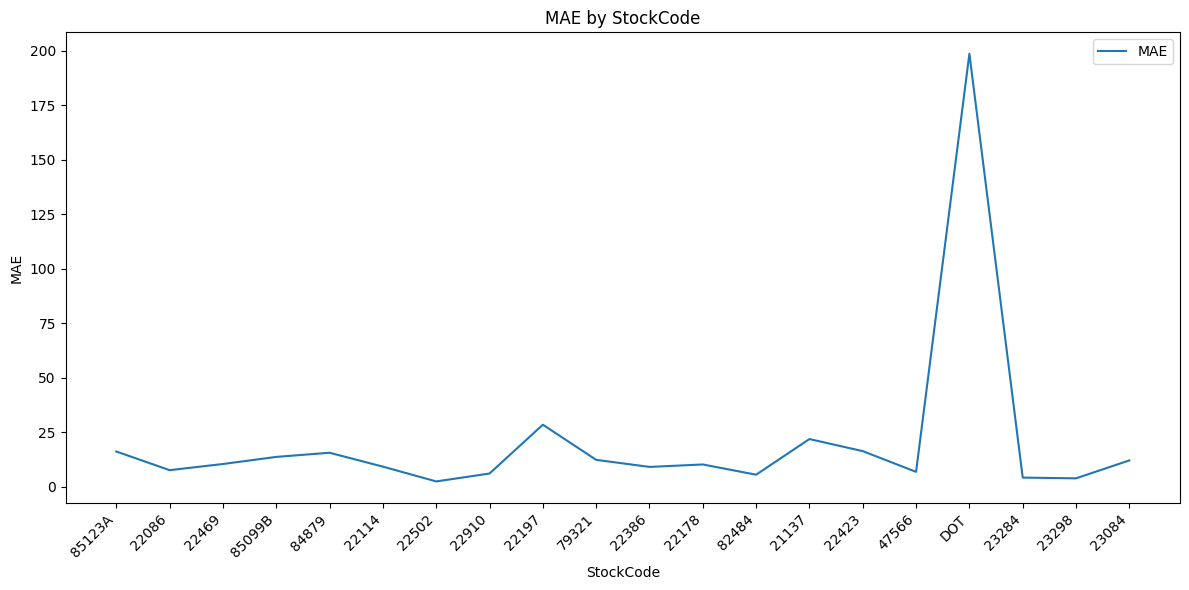

In [80]:
quantiles = [0.5]
mae_by_stockcode = {}

for stockcode in all_gam_results_uni['StockCode'].unique():
    stock_data = all_gam_results_uni[all_gam_results_uni['StockCode'] == stockcode]
    mae_by_stockcode[stockcode] = calculate_mae(stock_data, quantiles)


# Average MAE across quantiles for each stock code
average_mae = {}
for stockcode, mae_values in mae_by_stockcode.items():
    average_mae[stockcode] = sum(mae_values.values()) / len(mae_values)

# Create a DataFrame from the results
mae_df_uni = pd.DataFrame(list(average_mae.items()), columns=['StockCode', 'Average_MAE'])

# df_metrics1 = pd.merge(rmse_df, mae_df, on='StockCode', how='inner')

plt.figure(figsize=(12, 6))
# plt.plot(df_metrics1['StockCode'], df_metrics1['RMSE'], label='RMSE')
plt.plot(mae_df_uni['StockCode'], mae_df_uni['Average_MAE'], label='MAE')

plt.xlabel('StockCode')
plt.ylabel('MAE')
plt.title('MAE by StockCode')
plt.legend()
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

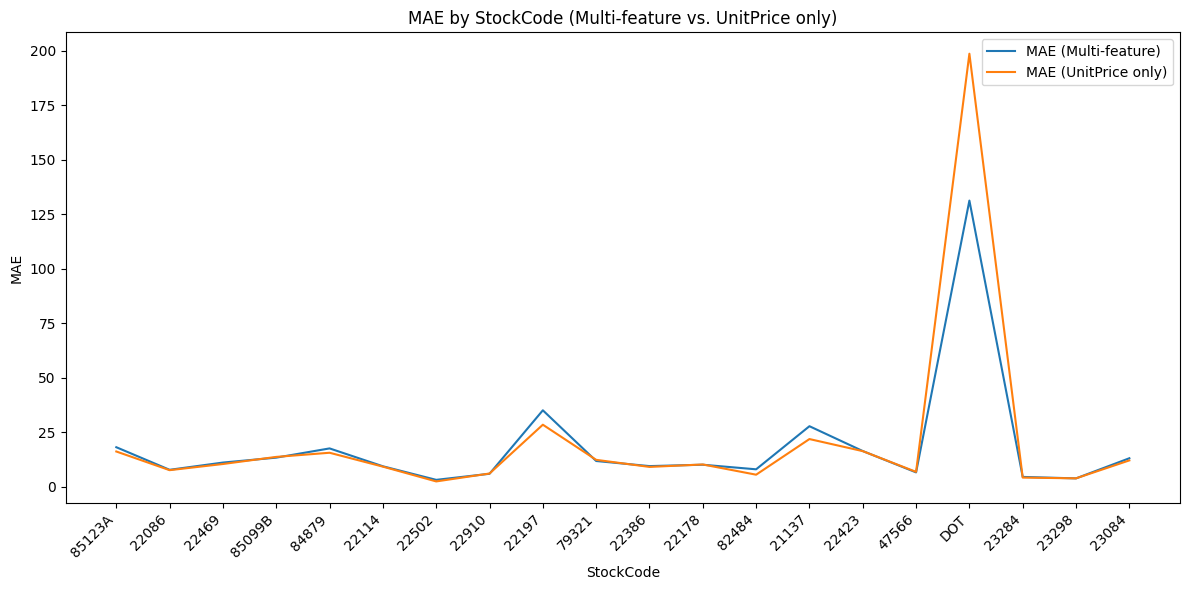

In [81]:
# prompt: plot mae_df_uni and mae_df in one chart

plt.figure(figsize=(12, 6))
plt.plot(mae_df['StockCode'], mae_df['Average_MAE'], label='MAE (Multi-feature)')
plt.plot(mae_df_uni['StockCode'], mae_df_uni['Average_MAE'], label='MAE (UnitPrice only)')

plt.xlabel('StockCode')
plt.ylabel('MAE')
plt.title('MAE by StockCode (Multi-feature vs. UnitPrice only)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


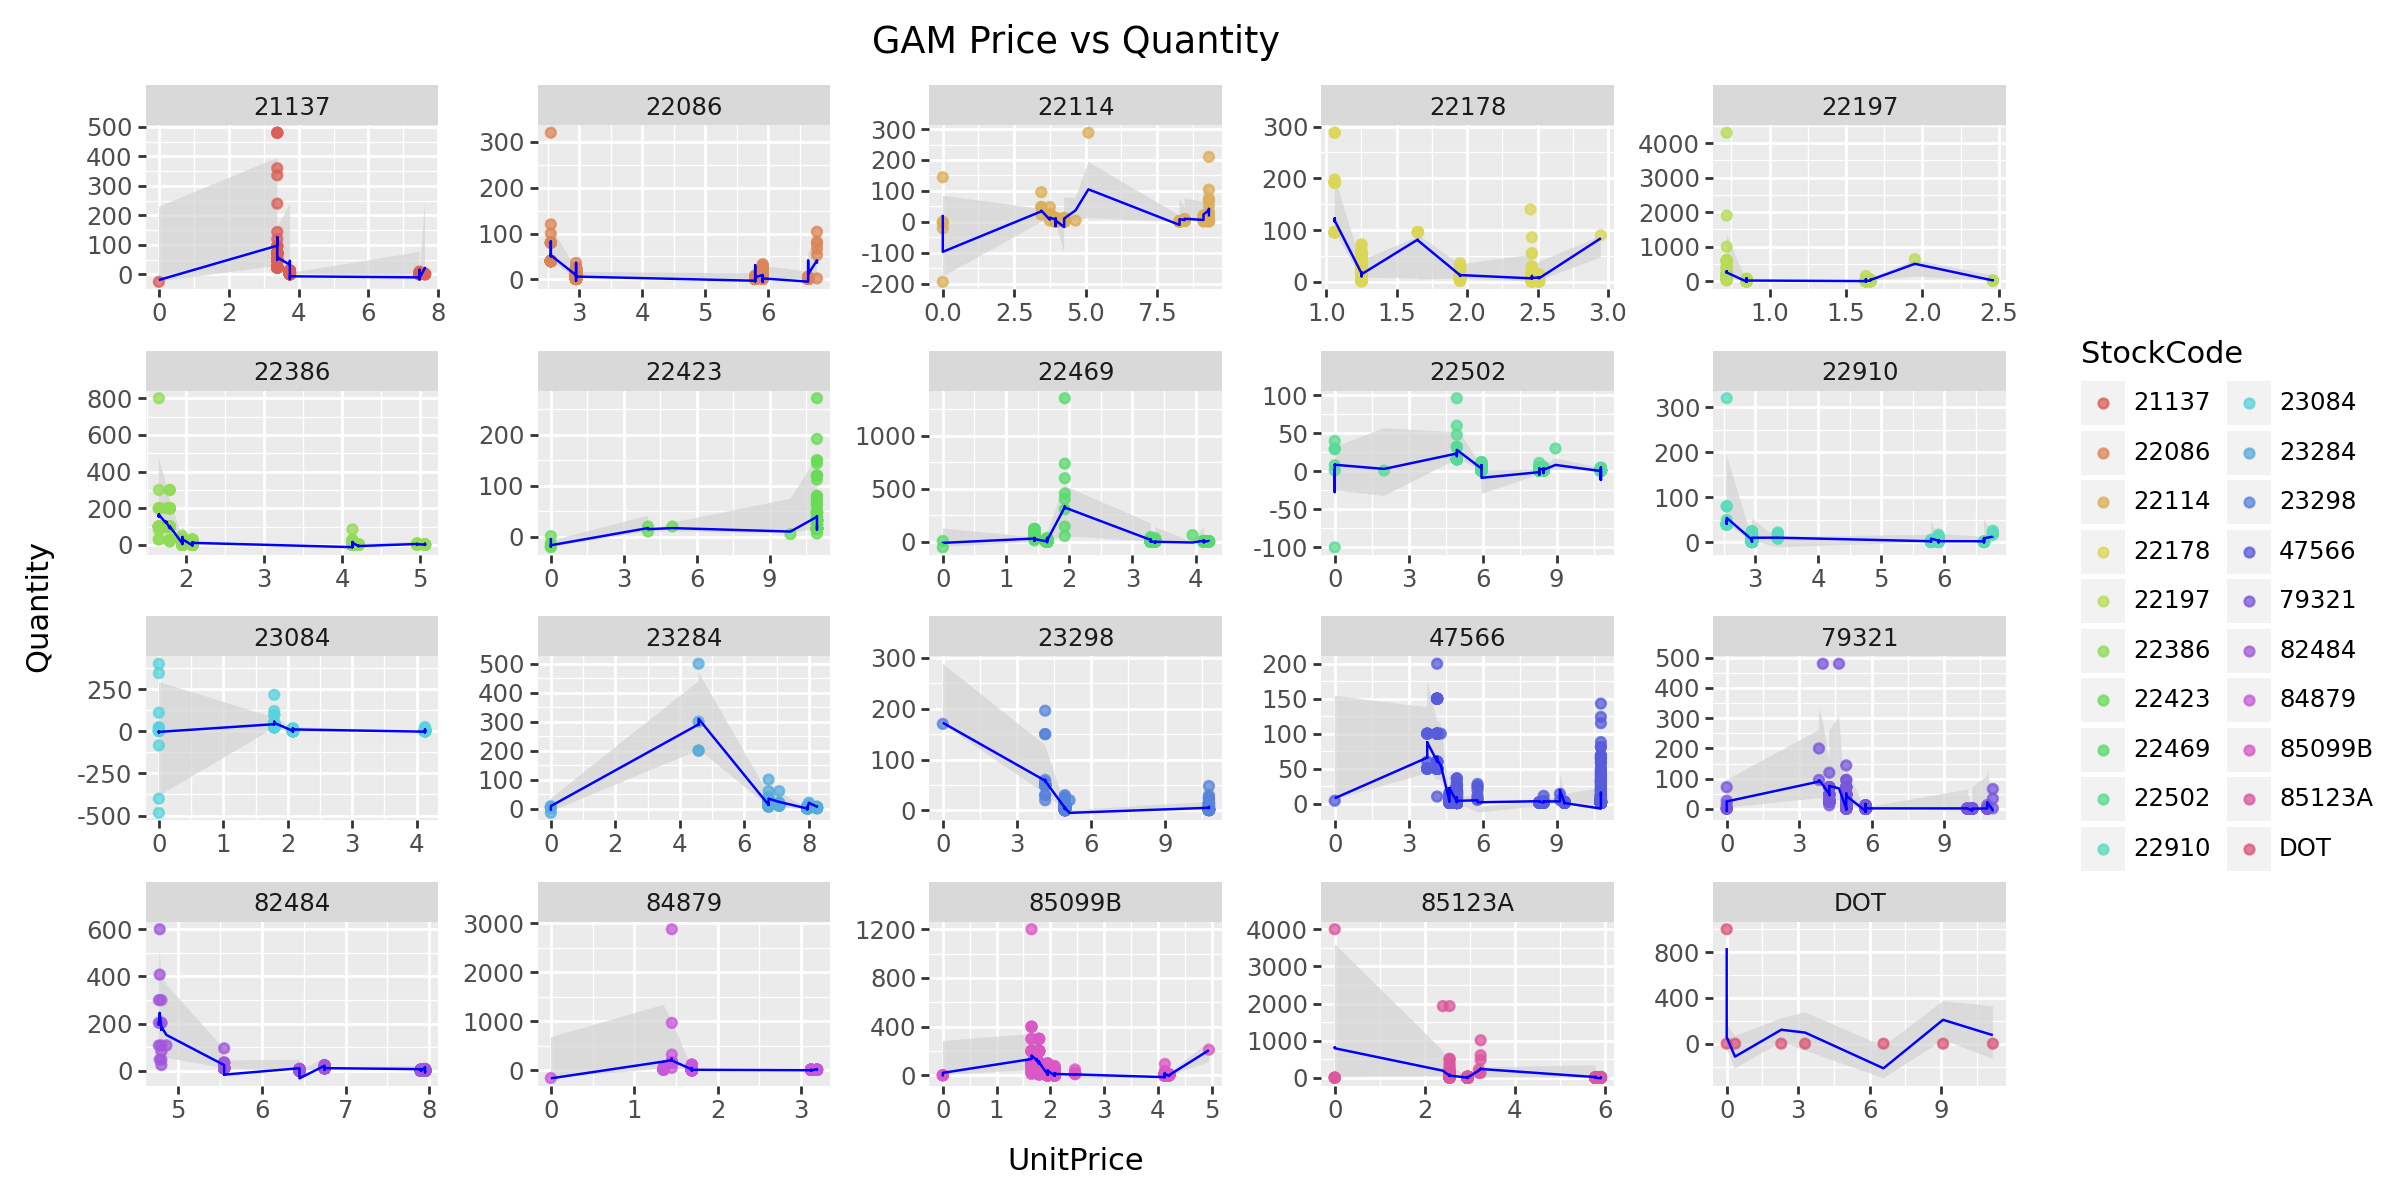

In [73]:
(ggplot(
    data = all_gam_results,
    mapping = aes(x='UnitPrice', y='Quantity', color='StockCode', group= 'StockCode') ) +
    geom_ribbon(aes(ymax= 'pred_0.975', ymin= 'pred_0.025'),
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
    geom_point(alpha=0.75) +
    geom_line(aes(y='pred_0.5'), color='blue') +
    facet_wrap('StockCode', scales='free') +
    labs(title='GAM Price vs Quantity') +
    theme(figure_size=(12,6))
)

In [74]:
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['UnitPrice'] * all_gam_results[col]

# Actual revenue
all_gam_results['revenue_actual'] = all_gam_results['UnitPrice'] * all_gam_results['Quantity']
all_gam_results.sample(5)

,UnitPrice,StockCode,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
4745,4.95,47566,3,2.045851,4.961774,12.846401,10.126962,24.560782,63.589684,14.85
5201,1.69,84879,4,-2.526704,3.621450,32.770129,-4.270130,6.120250,55.381518,6.76
12174,1.79,85099B,100,38.057104,104.773298,250.215405,68.122216,187.544203,447.885575,179.00
467,0.85,22197,25,-7.150069,-9.548607,7.307732,-6.077559,-8.116316,6.211573,21.25
3451,5.95,22502,4,1.656609,4.204261,10.340348,9.856824,25.015355,61.525070,23.80


In [75]:
best_50 = (
    all_gam_results
    .groupby('StockCode')
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 97.5% percentile revenue is the max
best_975 = (
    all_gam_results
    .groupby('StockCode')
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 2.5% percentile revenue is the max
best_025 = (
    all_gam_results
    .groupby('StockCode')
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))
    .reset_index(level=0, drop=True)
)

<ipython-input-75-fdc2b20b42a9>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<ipython-input-75-fdc2b20b42a9>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<ipython-input-75-fdc2b20b42a9>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `incl

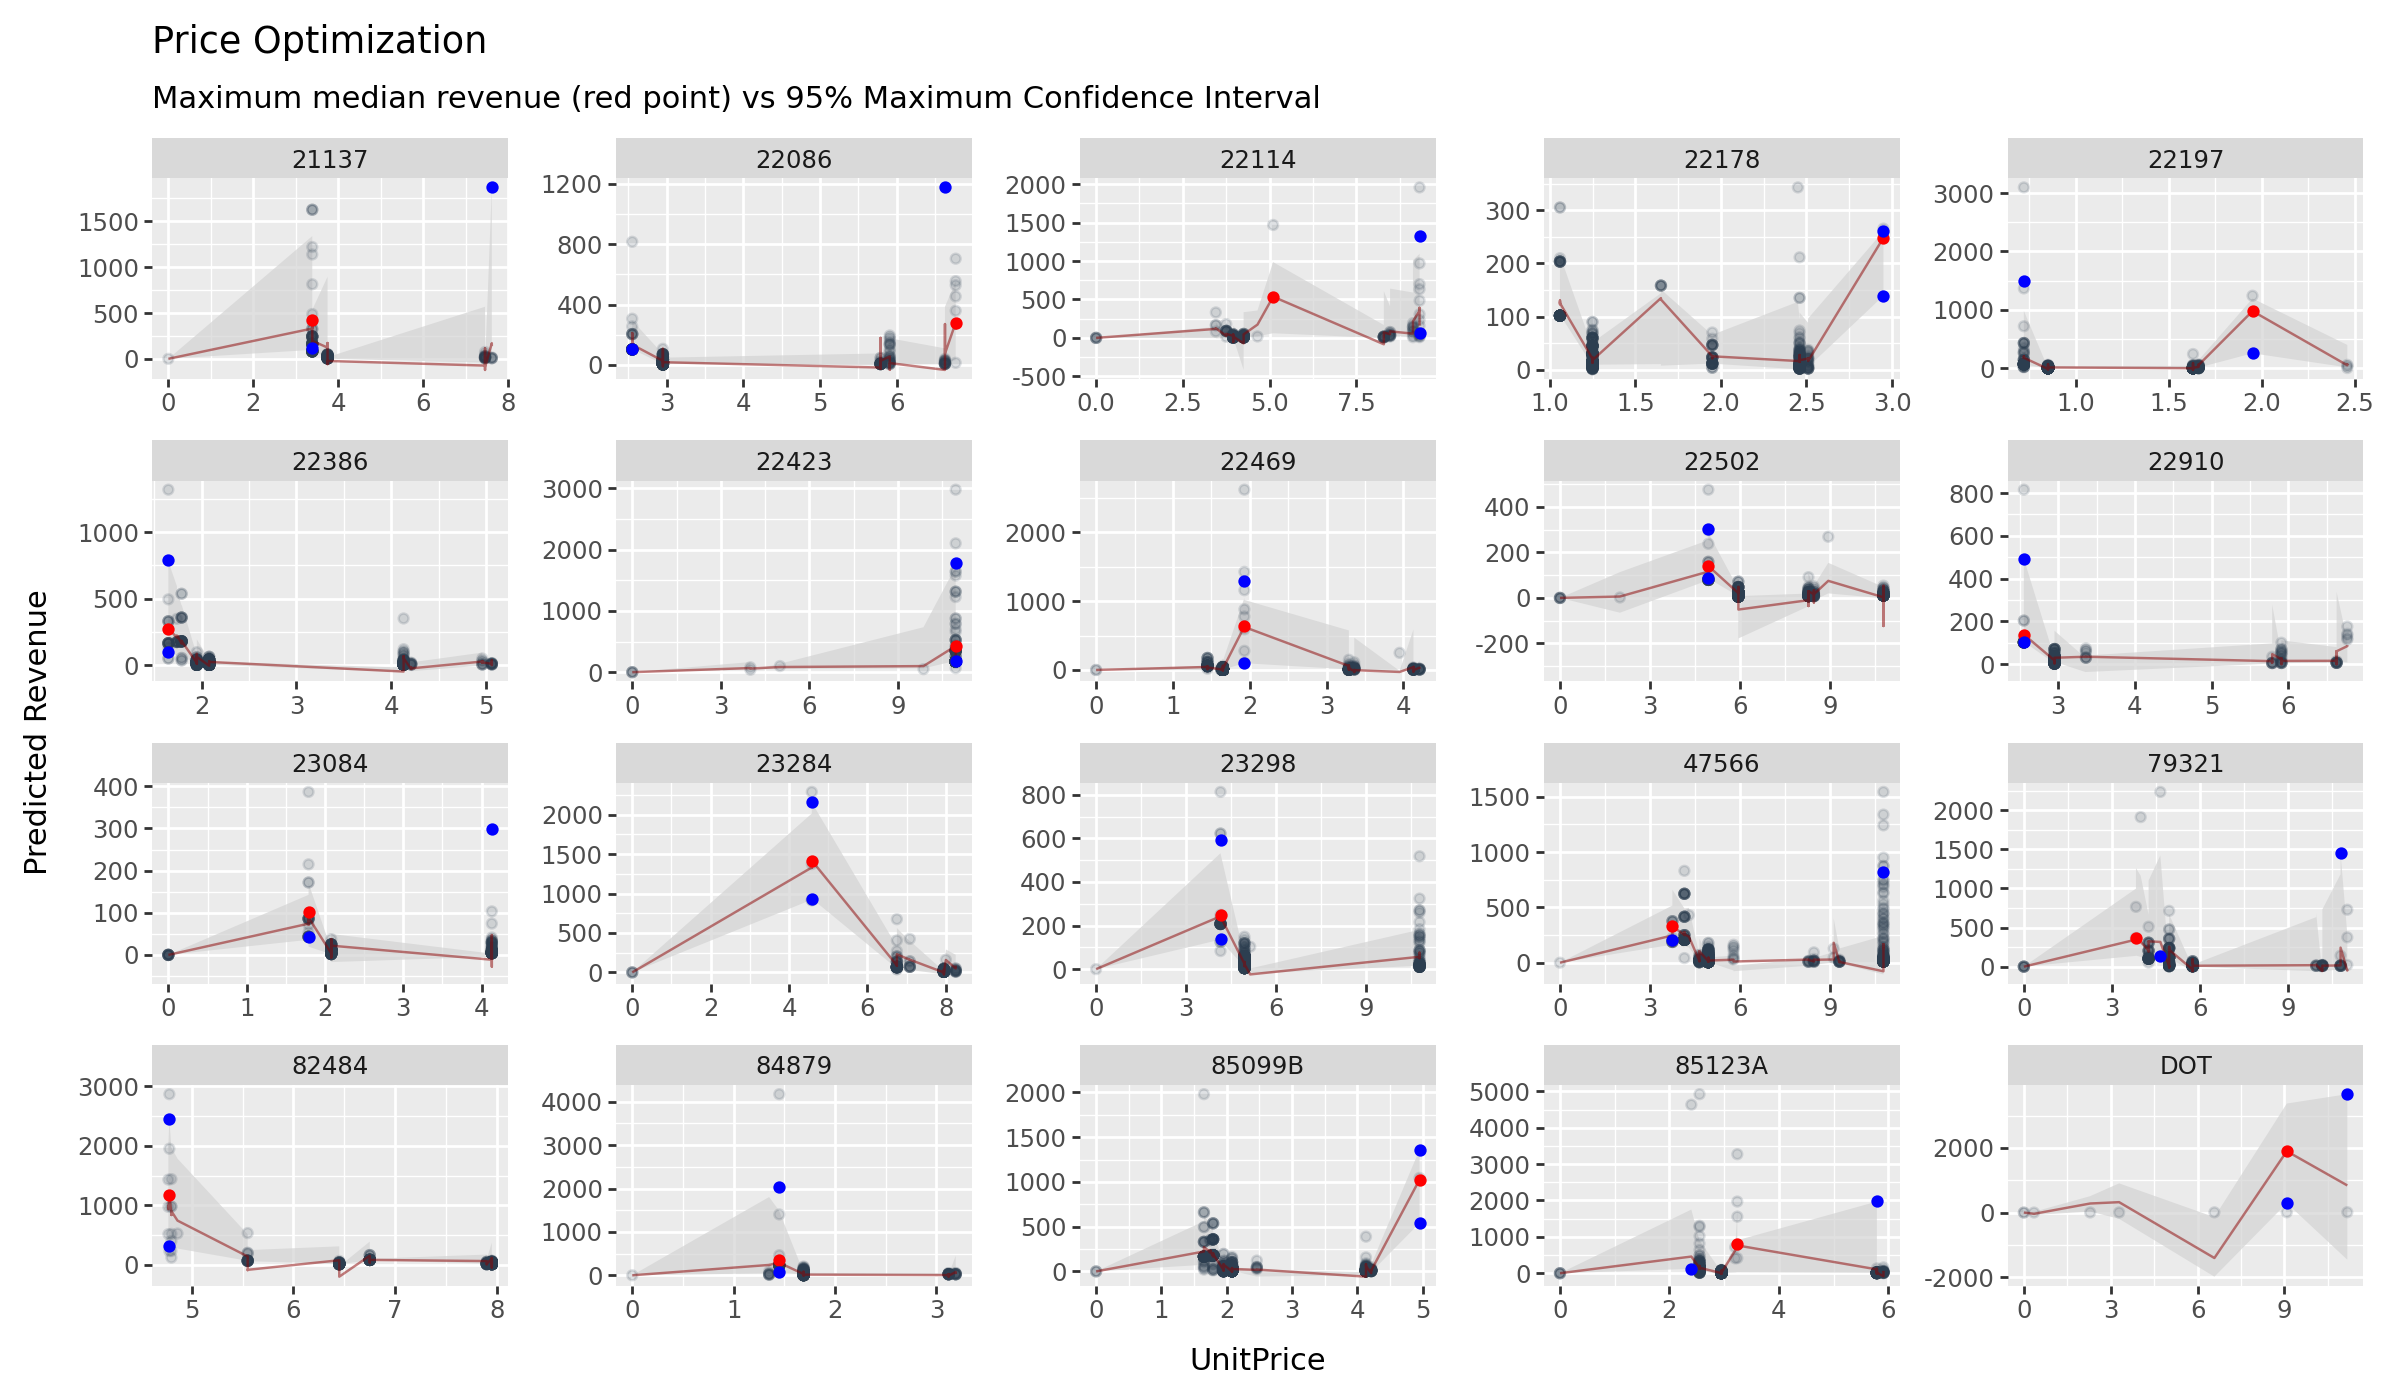

In [76]:
(ggplot(
    # Data
    data = all_gam_results,
    # Axes
    mapping = aes(x='UnitPrice', y='revenue_pred_0.5', color='StockCode', group='StockCode') ) +
# Adding the Band
geom_ribbon(aes(ymax= 'revenue_pred_0.975', ymin= 'revenue_pred_0.025'),
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
# Adding the points
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +
# Adding 50th percentile line
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5, color='darkred') +
# Addimg the 50th pct points
geom_point(data=best_50, color='red') +
# Addimg the 97th pct points
geom_point(data=best_975, mapping= aes(y='revenue_pred_0.975'), color='blue') +
# Addimg the 2.5th pct points
geom_point(data=best_025, mapping= aes(y='revenue_pred_0.025'), color='blue') +
# Wraps by product
facet_wrap('StockCode', scales='free') +
# Labels
labs(
    title='Price Optimization',
    subtitle='Maximum median revenue (red point) vs 95% Maximum Confidence Interval',
    x= 'UnitPrice',
    y= 'Predicted Revenue'
    ) +
theme(figure_size=(12,7))

)